**matplotlib likes to whine in this one, so I'm turning off warnings**

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Four: Beautiful maps with Basemap

**MOST OF THIS ONE IS READING**, you only have to do a little work down at the end. Since you probably didn't install Basemap during class, you'll need to run this:

* `pip3 install https://github.com/matplotlib/basemap/archive/v1.0.7rel.tar.gz`

# Part Zero: Importing Basemap and making simple maps

After the trash we've been dealing with, Basemap is insane. Check this out:

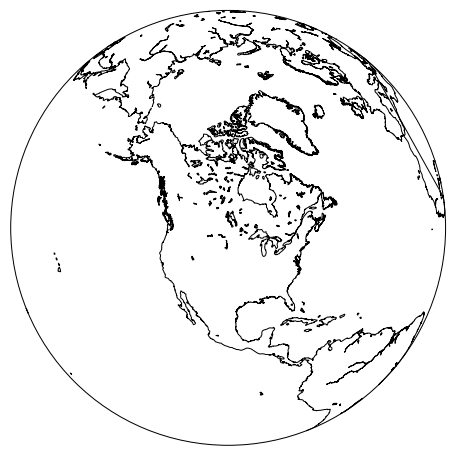

In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Set the size of the map
plt.figure(figsize=(8,8))

# Set the projection and the center
map = Basemap(projection='ortho', lat_0=50, lon_0=-100, resolution='l', area_thresh=1000.0)

# Draw some coastlines
map.drawcoastlines()

# Show the map
plt.show()

Oh is that boring trash to you? Do you want something better?

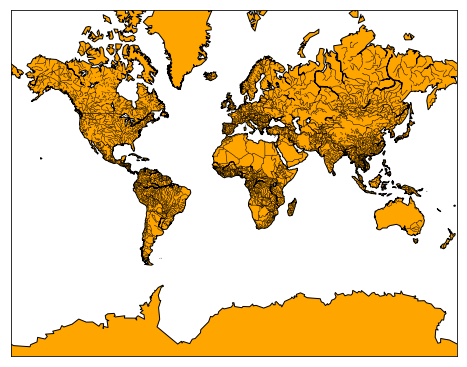

In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Set the size of the map
plt.figure(figsize=(8,8))

# Set the projection and the center
# Options stolen from https://matplotlib.org/basemap/users/merc.html
map = Basemap(projection='merc', llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

# Draw some other stuff
map.drawcoastlines()
map.drawcountries()
map.drawrivers()

# Color some stuff in
map.fillcontinents(color='orange')

# Show the map
plt.show()

Still sleeping?

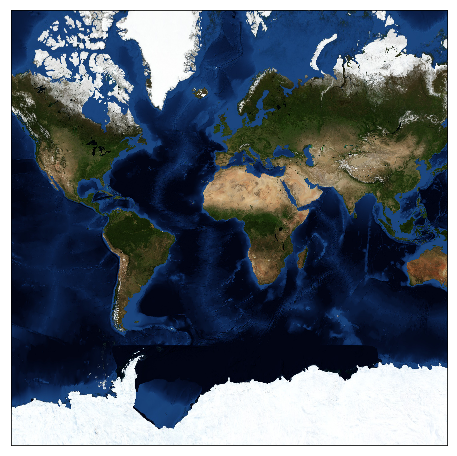

In [4]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

# Set the size of the map
plt.figure(figsize=(8,8))

# Set the projection and the center
# Adjusted options from above because you can't do -180 to 180 with longitude
map = Basemap(projection='merc', llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-140,urcrnrlon=140,lat_ts=20,resolution='c')

# Blue marble
# https://visibleearth.nasa.gov/view_cat.php?categoryID=1484
map.bluemarble()

# Show the map
plt.show()

*Whistles softly*

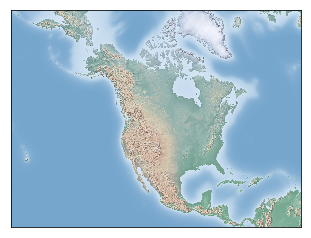

In [5]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
m.shadedrelief()
plt.show()


You can find more at [https://matplotlib.org/basemap/users/geography.html](https://matplotlib.org/basemap/users/geography.html) (although it's sometimes kinda tough to understand the options).

# Part One: Plotting points from geopandas on Basemap

First of all, let's import our data.

In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
df = pd.read_csv('worldcapitals.csv')
points = df.apply(lambda z: Point(z.Longitude, z.Latitude), axis=1)
capitals = gpd.GeoDataFrame(df, geometry=points)
capitals.crs = {'init': 'epsg:4326'}
capitals.head(2)

,GeoNameId,Name,Country,Latitude,Longitude,geometry
0,292968,Abu Dhabi,AE,24.46667,54.36667,POINT (54.36666999999999 24.46667)
1,2352778,Abuja,NG,9.05735,7.48976,POINT (7.48976 9.05735)


So we know how to plot them using geopandas...

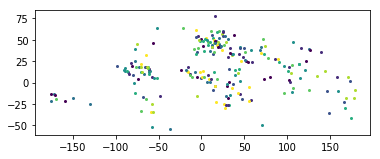

In [8]:
capitals.plot()

### CONVERTING A SINGLE POINT TO BASEMAP'S COORDINATE SYSTEM

...but using Basemap makes things a little different.

Your map has a `.plot` method that can plot a single point on the map, but it won't accept latitude and longitude! Using the latitude and longitude of NYC, look at where the red dot ends up on the map below.

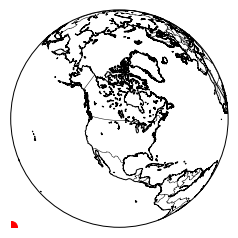

In [9]:
map = Basemap(projection='ortho', lat_0=50, lon_0=-100, resolution='l', area_thresh=1000.0)
map.drawcoastlines()
map.drawcountries()

# Try to plot NYC
map.plot(-74.0059, 40.7128, 'bo', markersize=12, color='red')

plt.show()

But! If you ask nicely, your map will convert lon/lat pairs into x/y coordinates for you.

In [10]:
map = Basemap(projection='ortho', lat_0=50, lon_0=-100, resolution='l', area_thresh=1000.0)
# "Where do you think -74.0059, 40.7128 belongs?"
map(-74.0059, 40.7128)

(8487507.138926657, 5717052.2505567875)

Great, an x of 8487507 and a y of 5717052. What if we plug those coordinates into `.plot`?

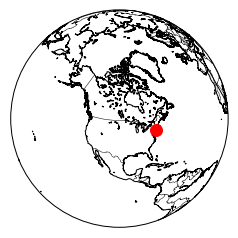

In [11]:
map = Basemap(projection='ortho', lat_0=50, lon_0=-100, resolution='l', area_thresh=1000.0)
map.drawcoastlines()
map.drawcountries()

# Try to plot NYC using the new x/y coords
map.plot(8487507.138926657, 5717052.2505567875, 'bo', markersize=12, color='red')

plt.show()

Perfect! But **we want to do this automatically**, so it should look something like this...

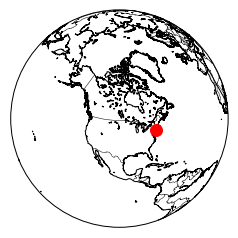

In [12]:
map = Basemap(projection='ortho', lat_0=50, lon_0=-100, resolution='l', area_thresh=1000.0)
map.drawcoastlines()
map.drawcountries()

# Convert lon/lat into x/y
x, y = map(-74.0059, 40.7128)

# Try to plot NYC using the new x/y coords
map.plot(x, y, 'bo', markersize=12, color='red')

plt.show()

### BUT: A caveat

**If we're going to be honest here**, you *can technically sometimes also* plot latitude and longitude on the map directly, you just need to send `latlon=True` when plotting.

**BUT:** It's buggy, and when you have big data or data that goes outside of the map or crosses the back of the map or a hundred other little edge cases, it'll freak out on you and give an error. So we're doing it the hard way.

I'm sorry, yes, but that's life. You can see it in action below, and you're free to use it (until you come across the errors, at which point you'll know to switch to reprojecting).

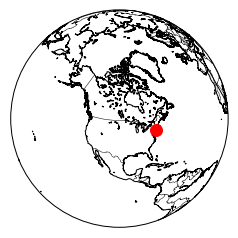

In [13]:
map = Basemap(projection='ortho', lat_0=50, lon_0=-100, resolution='l', area_thresh=1000.0)
map.drawcoastlines()
map.drawcountries()

# Just use lon/lat and pass latlon=True when plotting
lon = -74.0059
lat = 40.7128
map.plot(lon, lat, 'bo', markersize=12, color='red', latlon=True)

plt.show()

## CONVERTING MANY POINTS TO BASEMAP'S COORDINATE SYSTEM

So we did it with *one* point, how about doing it with many? First let's move the map show more of the world. I'm going to use [http://geojson.io/](http://geojson.io/) to find out the coordinates I want to use for the lower left and upper right of the map. You feed these to `llcrnrlat` (lower left corner right latitude), `llcrnrlon`, `urcrnrlat` and `urcrnrlon` (upper right corner longitude).

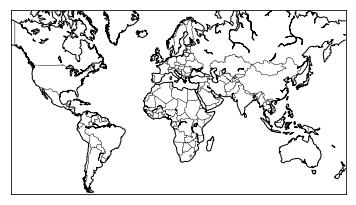

In [14]:
map = Basemap(projection='merc', llcrnrlat=-56, llcrnrlon=-145, urcrnrlat=73, urcrnrlon=177)
map.drawcoastlines()
map.drawcountries()
plt.show()

What are a few capitals?

In [15]:
capitals.head(5)

,GeoNameId,Name,Country,Latitude,Longitude,geometry
0,292968,Abu Dhabi,AE,24.46667,54.36667,POINT (54.36666999999999 24.46667)
1,2352778,Abuja,NG,9.05735,7.48976,POINT (7.48976 9.05735)
2,2306104,Accra,GH,5.55602,-0.19690,POINT (-0.1969 5.556019999999999)
3,4030723,Adamstown,PN,-25.06597,-130.10147,POINT (-130.10147 -25.06597)
4,344979,Addis Ababa,ET,9.02497,38.74689,POINT (38.74689 9.02497)


If you give `map` a list of longitudes and latitudes, it'll convert them just as nicely for you!

In [16]:
map = Basemap(projection='merc', llcrnrlat=-56, llcrnrlon=-145, urcrnrlat=73, urcrnrlon=177)
# I wrote up lists of longitudes and latitudes from above
lons = [54.36667, 7.48976, 7.48976, -130.10147, 38.74689]
lats = [24.46667, 9.05735, 5.55602, -25.06597, 9.02497]
# Feed them to the map to have them converted
map(lons, lats)

([22168551.80720552,
  16956079.692901205,
  16956079.692901205,
  1656640.1703765504,
  20431712.333751142],
 [10357186.18871217,
  8561306.29688398,
  8168725.854461627,
  4669332.9870224185,
  8557660.510484938])

Additionally, `.plot` accepts lists of x and y coordinates. Now, just like we did before, we'll convert them using `map()` and display them using `.plot` all in one cell.

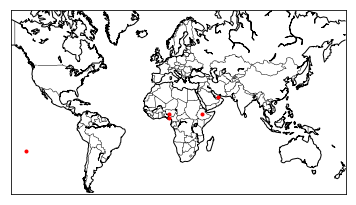

In [17]:
map = Basemap(projection='merc', llcrnrlat=-56, llcrnrlon=-145, urcrnrlat=73, urcrnrlon=177)
map.drawcoastlines()
map.drawcountries()

# Here are our longitudes and latitudes
lons = [54.36667, 7.48976, 7.48976, -130.10147, 38.74689]
lats = [24.46667, 9.05735, 5.55602, -25.06597, 9.02497]
# Convert them to Basemap's x and y values
x, y = map(lons, lats)
# Plot them on the map
map.plot(x, y, 'bo', markersize=3, color='red')

plt.show()

And yes, Adamstown is located way over there in the middle of the ocean.

**Now we just need to do this with our dataframe.** Seems like it should be easy enough - instead of making a list of latitudes and longitudes, we should be able to just do `capitals.Latitude` and `capitals.Longitude`, right?

In [18]:
capitals.Latitude.head()

0    24.46667
1     9.05735
2     5.55602
3   -25.06597
4     9.02497
Name: Latitude, dtype: float64

Seems like it'll work. Let's try it!

SystemError: <class 'RuntimeError'> returned a result with an error set

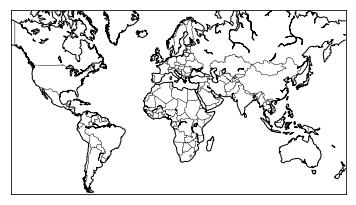

In [19]:
map = Basemap(projection='merc', llcrnrlat=-56, llcrnrlon=-145, urcrnrlat=73, urcrnrlon=177)
map.drawcoastlines()
map.drawcountries()

lons = capitals['Longitude']
lats = capitals['Latitude']
x, y = map(lons, lats)
map.plot(x, y, 'bo', markersize=2, color='red')

plt.show()

**IT DOES NOT WORK.** It's because `capitals['Longitude']` is technically a *Series*, and Basemap only understands *lists*. It doesn't get what pandas is talking about.

So all we gotta do is convert it to a list!

In [20]:
# Convert to a list, look at the first five...
capitals['Longitude'].tolist()[:5]

[54.36666999999999, 7.48976, -0.1969, -130.10147, 38.74689]

Now let's actually do it!

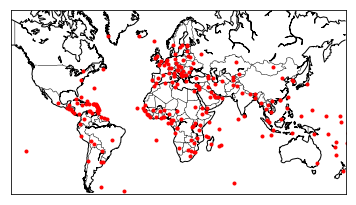

In [21]:
map = Basemap(projection='merc', llcrnrlat=-56, llcrnrlon=-145, urcrnrlat=73, urcrnrlon=177)
map.drawcoastlines()
map.drawcountries()

# Pull lons and lats from our dataframe
# Convert to list
lons = capitals['Longitude'].tolist()
lats = capitals['Latitude'].tolist()
# Convert to Basemap's coordinate system
x, y = map(lons, lats)
# and plot them
map.plot(x, y, 'bo', markersize=3, color='red')

plt.show()

There we go! **Success!**

## YOUR WORK: 

Read in `volcanoes.csv` and plot them on top of a shaded relief map **of Iceland**.

**If your Iceland looks ugly,** try upping the resolution of your coastlines by passing `resolution='i'` (intermediate) or `resolution='h'` (high) to your Basemap.

In [44]:
import pandas as pd
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
volcanoes = pd.read_csv('volcanoes.csv')
volcanoes.head()

,X,Y,VOLCANX020,NUMBER,NAME,LOCATION,STATUS,ELEV,TYPE,TIMEFRAME,LAT,LONG
0,120.349998,15.130000,1,0703-083,Pinatubo,Luzon-Philippines,Historical,1486,Stratovolcano,D1,15.130,120.35
1,120.550003,16.330002,2,0703-086,Santo Tomas,Luzon-Philippines,Uncertain,2260,Stratovolcano,?,16.330,120.55
2,121.180000,21.830002,3,0801-02=,Unnamed,Taiwan-E of,Historical,-115,Submarine volcano,D3,21.830,121.18
3,120.400002,14.704999,4,0703-082,Natib,Luzon-Philippines,Holocene?,1287,Stratovolcano,?,14.705,120.40
4,120.500000,14.500001,5,0703-081,Mariveles,Luzon-Philippines,Radiocarbon,1420,Stratovolcano,D7,14.500,120.50


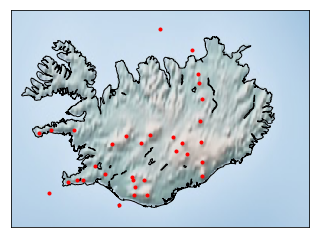

In [78]:
map = Basemap(projection='merc',resolution='h',llcrnrlat=63,urcrnrlat=67, llcrnrlon=-25,urcrnrlon=-12)

map.shadedrelief()
map.drawcoastlines()

# Pull lons and lats from our dataframe
# Convert to list
lons = volcanoes['LONG'].tolist()
lats = volcanoes['LAT'].tolist()
# Convert to Basemap's coordinate system
x, y = map(lons, lats)
# and plot them
map.plot(x, y, 'bo', markersize=3, color='red')

plt.show()

Kind of cool, right?